In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [2]:
df = pd.read_csv('data2.csv')
df.head()

,id,expiration_id,src_ip,src_mac,src_oui,src_port,dst_ip,dst_mac,dst_oui,dst_port,...,dst2src_bytes,application_name,application_category_name,application_is_guessed,application_confidence,requested_server_name,client_fingerprint,server_fingerprint,user_agent,content_type
0,0,0,fe80::d0f5:d5ff:feac:ef44,d2:f5:d5:ac:ef:44,d2:f5:d5,0,ff02::2,33:33:00:00:00:02,33:33:00,0,...,0,ICMPV6,Network,0,6,NaN,NaN,NaN,NaN,NaN
1,1,0,fe80::1cd0:31ff:fe7f:15fd,1e:d0:31:7f:15:fd,1e:d0:31,5353,ff02::fb,33:33:00:00:00:fb,33:33:00,5353,...,0,MDNS,Network,0,6,_ipps._tcp.local,NaN,NaN,NaN,NaN
2,2,0,fe80::d0f5:d5ff:feac:ef44,d2:f5:d5:ac:ef:44,d2:f5:d5,5353,ff02::fb,33:33:00:00:00:fb,33:33:00,5353,...,0,MDNS,Network,0,6,_ipps._tcp.local,NaN,NaN,NaN,NaN
3,3,0,10.0.0.104,00:00:00:00:00:04,00:00:00,59038,10.0.0.101,00:00:00:00:00:01,00:00:00,80,...,300,HTTP,Web,1,1,NaN,NaN,NaN,NaN,NaN
4,4,0,10.0.0.101,00:00:00:00:00:01,00:00:00,80,10.0.0.104,00:00:00:00:00:04,00:00:00,59070,...,0,HTTP,Web,1,1,NaN,NaN,NaN,NaN,NaN


In [3]:
df.columns

Index(['id', 'expiration_id', 'src_ip', 'src_mac', 'src_oui', 'src_port',
       'dst_ip', 'dst_mac', 'dst_oui', 'dst_port', 'protocol', 'ip_version',
       'vlan_id', 'tunnel_id', 'bidirectional_first_seen_ms',
       'bidirectional_last_seen_ms', 'bidirectional_duration_ms',
       'bidirectional_packets', 'bidirectional_bytes', 'src2dst_first_seen_ms',
       'src2dst_last_seen_ms', 'src2dst_duration_ms', 'src2dst_packets',
       'src2dst_bytes', 'dst2src_first_seen_ms', 'dst2src_last_seen_ms',
       'dst2src_duration_ms', 'dst2src_packets', 'dst2src_bytes',
       'application_name', 'application_category_name',
       'application_is_guessed', 'application_confidence',
       'requested_server_name', 'client_fingerprint', 'server_fingerprint',
       'user_agent', 'content_type'],
      dtype='object')

In [4]:
# Only include IPv4
df = df[df['ip_version'] == 4]
print(df.shape)
df.head()

(27735, 38)


,id,expiration_id,src_ip,src_mac,src_oui,src_port,dst_ip,dst_mac,dst_oui,dst_port,...,dst2src_bytes,application_name,application_category_name,application_is_guessed,application_confidence,requested_server_name,client_fingerprint,server_fingerprint,user_agent,content_type
3,3,0,10.0.0.104,00:00:00:00:00:04,00:00:00,59038,10.0.0.101,00:00:00:00:00:01,00:00:00,80,...,300,HTTP,Web,1,1,NaN,NaN,NaN,NaN,NaN
4,4,0,10.0.0.101,00:00:00:00:00:01,00:00:00,80,10.0.0.104,00:00:00:00:00:04,00:00:00,59070,...,0,HTTP,Web,1,1,NaN,NaN,NaN,NaN,NaN
5,5,0,10.0.0.101,00:00:00:00:00:01,00:00:00,80,10.0.0.104,00:00:00:00:00:04,00:00:00,59116,...,0,HTTP,Web,1,1,NaN,NaN,NaN,NaN,NaN
6,6,0,10.0.0.104,00:00:00:00:00:04,00:00:00,59130,10.0.0.101,00:00:00:00:00:01,00:00:00,80,...,2940,HTTP,Web,1,1,NaN,NaN,NaN,NaN,NaN
7,7,0,10.0.0.104,00:00:00:00:00:04,00:00:00,59212,10.0.0.101,00:00:00:00:00:01,00:00:00,80,...,0,HTTP,Web,1,1,NaN,NaN,NaN,NaN,NaN


In [5]:
# Rebuild index
df = df.reset_index(drop=True)
df.head()

,id,expiration_id,src_ip,src_mac,src_oui,src_port,dst_ip,dst_mac,dst_oui,dst_port,...,dst2src_bytes,application_name,application_category_name,application_is_guessed,application_confidence,requested_server_name,client_fingerprint,server_fingerprint,user_agent,content_type
0,3,0,10.0.0.104,00:00:00:00:00:04,00:00:00,59038,10.0.0.101,00:00:00:00:00:01,00:00:00,80,...,300,HTTP,Web,1,1,NaN,NaN,NaN,NaN,NaN
1,4,0,10.0.0.101,00:00:00:00:00:01,00:00:00,80,10.0.0.104,00:00:00:00:00:04,00:00:00,59070,...,0,HTTP,Web,1,1,NaN,NaN,NaN,NaN,NaN
2,5,0,10.0.0.101,00:00:00:00:00:01,00:00:00,80,10.0.0.104,00:00:00:00:00:04,00:00:00,59116,...,0,HTTP,Web,1,1,NaN,NaN,NaN,NaN,NaN
3,6,0,10.0.0.104,00:00:00:00:00:04,00:00:00,59130,10.0.0.101,00:00:00:00:00:01,00:00:00,80,...,2940,HTTP,Web,1,1,NaN,NaN,NaN,NaN,NaN
4,7,0,10.0.0.104,00:00:00:00:00:04,00:00:00,59212,10.0.0.101,00:00:00:00:00:01,00:00:00,80,...,0,HTTP,Web,1,1,NaN,NaN,NaN,NaN,NaN


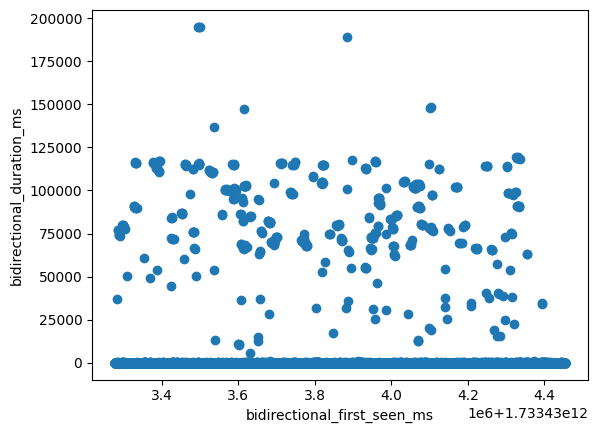

In [6]:
# Sort by bidirectional_first_seen_ms
df = df.sort_values(by='bidirectional_first_seen_ms')

# Visualize bidirectional_duration_ms against bidirectional_first_seen_ms
plt.scatter(df['bidirectional_first_seen_ms'], df['bidirectional_duration_ms'])
plt.xlabel('bidirectional_first_seen_ms')
plt.ylabel('bidirectional_duration_ms')
plt.show()

In [7]:
# Use log normal
df['log_duration_ms'] = np.log(df['bidirectional_duration_ms'] + 1)
# Use datetime for bidirectional_first_seen_ms
df['date_first_seen'] = pd.to_datetime(df['bidirectional_first_seen_ms'], unit='ms')
df.head()

,id,expiration_id,src_ip,src_mac,src_oui,src_port,dst_ip,dst_mac,dst_oui,dst_port,...,application_category_name,application_is_guessed,application_confidence,requested_server_name,client_fingerprint,server_fingerprint,user_agent,content_type,log_duration_ms,date_first_seen
22,26,0,10.0.0.104,00:00:00:00:00:04,00:00:00,57734,10.0.0.102,00:00:00:00:00:02,00:00:00,80,...,Web,1,1,NaN,NaN,NaN,NaN,NaN,3.218876,2024-12-05 21:14:37.363
23,27,0,10.0.0.104,00:00:00:00:00:04,00:00:00,59062,10.0.0.101,00:00:00:00:00:01,00:00:00,80,...,Web,1,1,NaN,NaN,NaN,NaN,NaN,3.258097,2024-12-05 21:14:37.363
24,28,0,10.0.0.101,00:00:00:00:00:01,00:00:00,80,10.0.0.104,00:00:00:00:00:04,00:00:00,59064,...,Web,1,1,NaN,NaN,NaN,NaN,NaN,2.995732,2024-12-05 21:14:37.455
25,29,0,10.0.0.104,00:00:00:00:00:04,00:00:00,57746,10.0.0.102,00:00:00:00:00:02,00:00:00,80,...,Web,1,1,NaN,NaN,NaN,NaN,NaN,3.258097,2024-12-05 21:14:37.536
26,30,0,10.0.0.101,00:00:00:00:00:01,00:00:00,80,10.0.0.104,00:00:00:00:00:04,00:00:00,59066,...,Web,1,1,NaN,NaN,NaN,NaN,NaN,3.178054,2024-12-05 21:14:37.541


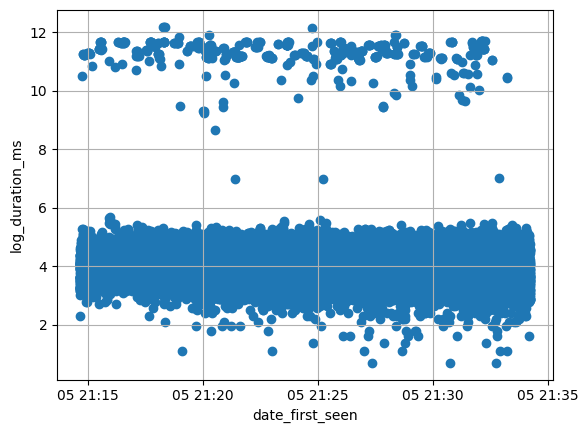

In [8]:
# Visualize log_duration_ms vs. date_first_seen
plt.scatter(df['date_first_seen'], df['log_duration_ms'])
plt.xlabel('date_first_seen')
plt.ylabel('log_duration_ms')
plt.grid(True)
plt.show()

In [9]:
# Create a new data frame with date_first_seen as the index
df_new = df.set_index('date_first_seen')
df_new = df_new[[
       'bidirectional_duration_ms', #'bidirectional_packets', 'bidirectional_bytes',
       #'src2dst_duration_ms',
       #'src2dst_packets',
       'src2dst_bytes',
       #'dst2src_duration_ms',
       #'dst2src_packets', 'dst2src_bytes',
       'src_ip', 'src_port',
       'dst_ip', 'dst_port'
       ]]
# normalize 'bidirectional_duration_ms', 'bidirectional_packets', 'bidirectional_bytes' with log
df_new['bidirectional_duration_ms'] = np.log(df_new['bidirectional_duration_ms'] + 1)
#df_new['bidirectional_packets'] = np.log(df_new['bidirectional_packets'] + 1)
#df_new['bidirectional_bytes'] = np.log(df_new['bidirectional_bytes'] + 1)
# normalize 'src2dst_duration_ms', 'src2dst_packets', 'src2dst_bytes',
# df_new['src2dst_duration_ms'] = np.log(df_new['src2dst_duration_ms'] + 1)
#df_new['src2dst_packets'] = np.log(df_new['src2dst_packets'] + 1)
df_new['src2dst_bytes'] = np.log(df_new['src2dst_bytes'] + 1)
# normalize 'dst2src_duration_ms', 'dst2src_packets', 'dst2src_bytes'
# df_new['dst2src_duration_ms'] = np.log(df_new['dst2src_duration_ms'] + 1)
#df_new['dst2src_packets'] = np.log(df_new['dst2src_packets'] + 1)
#df_new['dst2src_bytes'] = np.log(df_new['dst2src_bytes'] + 1)
# one hot encode src_ip and dst_ip
df_new = pd.get_dummies(df_new, columns=['src_ip', 'dst_ip'])
# normalize port
df_new['src_port'] /= 65535
df_new['dst_port'] /= 65535
# set as float
df_new = df_new.astype(float)
print(df_new.shape)
df_new.head()

(27735, 12)


,bidirectional_duration_ms,src2dst_bytes,src_port,dst_port,src_ip_10.0.0.101,src_ip_10.0.0.102,src_ip_10.0.0.103,src_ip_10.0.0.104,dst_ip_10.0.0.101,dst_ip_10.0.0.102,dst_ip_10.0.0.103,dst_ip_10.0.0.104
date_first_seen,,,,,,,,,,,,
2024-12-05 21:14:37.363,3.218876,13.866032,0.880964,0.001221,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2024-12-05 21:14:37.363,3.258097,6.142037,0.901228,0.001221,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2024-12-05 21:14:37.455,2.995732,7.660585,0.001221,0.901259,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2024-12-05 21:14:37.536,3.258097,11.796215,0.881147,0.001221,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2024-12-05 21:14:37.541,3.178054,7.623153,0.001221,0.901289,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


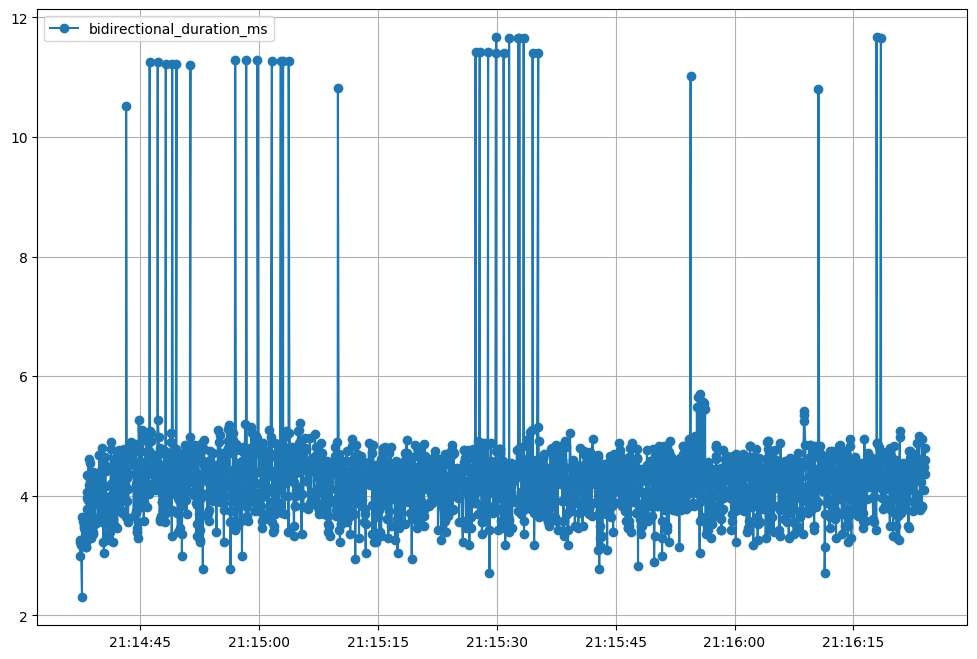

In [10]:
# Visualize all df_new in 1 scatter plot
# Set figsize
plt.figure(figsize=(12,8))
# Plot first n data
n_data = 2500
plt.plot(df_new.index[:n_data], df_new['bidirectional_duration_ms'][:n_data], 'o-', label='bidirectional_duration_ms')
#plt.plot(df_new.index[:n_data], df_new['src2dst_bytes'][:n_data], 'o-', label='src2dst_bytes')

# plt.scatter(df_new.index, df_new['bidirectional_packets'], label='bidirectional_packets')
# plt.scatter(df_new.index, df_new['bidirectional_bytes'], label='bidirectional_bytes')
"""
plt.scatter(df_new.index, df_new['src2dst_duration_ms'])
plt.scatter(df_new.index, df_new['src2dst_packets'])
plt.scatter(df_new.index, df_new['src2dst_bytes'])
plt.scatter(df_new.index, df_new['dst2src_duration_ms'])
plt.scatter(df_new.index, df_new['dst2src_packets'])
plt.scatter(df_new.index, df_new['dst2src_bytes'])
"""
plt.legend()
plt.grid(True)
plt.show()


In [11]:
# Calculate bidirectional_duration_ms autocorrelation
df_new['bidirectional_duration_ms'].autocorr()

0.04802089005390879

In [12]:
# Calculate df_new cross correlation
df_new.corr()

,bidirectional_duration_ms,src2dst_bytes,src_port,dst_port,src_ip_10.0.0.101,src_ip_10.0.0.102,src_ip_10.0.0.103,src_ip_10.0.0.104,dst_ip_10.0.0.101,dst_ip_10.0.0.102,dst_ip_10.0.0.103,dst_ip_10.0.0.104
bidirectional_duration_ms,1.000000,0.203376,0.208888,-0.210607,0.064137,0.026275,-0.041289,-0.048838,-0.026388,-0.063589,0.060301,0.030217
src2dst_bytes,0.203376,1.000000,0.627549,-0.637919,0.003094,-0.010432,0.012444,-0.005190,0.008092,-0.000762,0.005832,-0.013114
src_port,0.208888,0.627549,1.000000,-0.935834,-0.011606,-0.011500,0.012943,0.010069,0.006897,0.016089,-0.008732,-0.014361
dst_port,-0.210607,-0.637919,-0.935834,1.000000,0.005249,0.019486,-0.017479,-0.007124,-0.016363,-0.008294,0.004503,0.020182
src_ip_10.0.0.101,0.064137,0.003094,-0.011606,0.005249,1.000000,-0.330821,-0.335619,-0.332293,-0.331557,-0.336355,0.335966,0.334482
src_ip_10.0.0.102,0.026275,-0.010432,-0.011500,0.019486,-0.330821,1.000000,-0.334358,-0.331044,-0.330311,-0.335091,0.330140,0.337768
src_ip_10.0.0.103,-0.041289,0.012444,0.012943,-0.017479,-0.335619,-0.334358,1.000000,-0.335846,0.322561,0.344831,-0.333453,-0.336525
src_ip_10.0.0.104,-0.048838,-0.005190,0.010069,-0.007124,-0.332293,-0.331044,-0.335846,1.000000,0.336858,0.324043,-0.330148,-0.333189
dst_ip_10.0.0.101,-0.026388,0.008092,0.006897,-0.016363,-0.331557,-0.330311,0.322561,0.336858,1.000000,-0.335837,-0.329417,-0.332451
dst_ip_10.0.0.102,-0.063589,-0.000762,0.016089,-0.008294,-0.336355,-0.335091,0.344831,0.324043,-0.335837,1.000000,-0.334184,-0.337262


In [13]:
# If bidirectional_duration_ms > mean + 2 std, set label to 1, otherwise 0
df_new['label'] = df_new['bidirectional_duration_ms'].apply(lambda x: 1 if x > df_new['bidirectional_duration_ms'].mean() + 2 * df_new['bidirectional_duration_ms'].std() else 0)

df_majority = df_new[df_new['label'] == 0]
df_minority = df_new[df_new['label'] == 1]
df_majority_downsampled = df_majority.sample(n=df_minority.shape[0])
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
df_downsampled = df_downsampled.sample(frac=1).reset_index(drop=True)
df_downsampled['label'].value_counts()

X = df_downsampled.drop(columns=['label', 'bidirectional_duration_ms'], axis=1)
y = df_downsampled['label']

print(X.shape, y.shape)

(942, 11) (942,)


In [14]:
# Create a simple binary classifier
class BinaryClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BinaryClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [15]:
# Create a simple train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# Create train and test data loader
train_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_train.values).float(), torch.from_numpy(y_train.values).float())
test_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_test.values).float(), torch.from_numpy(y_test.values).float())

batch_size = 16
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

model = BinaryClassifier(input_size=X_train.shape[1], hidden_size=128, output_size=1)
model.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=5e-4)

epochs = 500
for epoch in range(epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target.unsqueeze(1))
        loss.backward()
        optimizer.step()

    model.eval()
    test_loss = 0
    correct = 0
    y_label = []
    y_pred = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target.unsqueeze(1)).item()
            pred = (output > 0.5).float()
            correct += pred.eq(target.view_as(pred)).sum().item()
            # save label and pred
            y_label.append(target.cpu().numpy())
            y_pred.append(pred.cpu().numpy())

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    # calculate f1 score
    from sklearn.metrics import f1_score
    y_label = np.concatenate(y_label)
    y_pred = np.concatenate(y_pred)
    f1 = f1_score(y_label, y_pred)

    print('Epoch: {} \tTraining Loss: {:.6f} \tTest Loss: {:.6f} \tTest Accuracy: {:.2f}% \tF1 Score: {:.2f}'.format(
        epoch+1, loss.item(), test_loss, accuracy, f1))

(753, 11) (189, 11) (753,) (189,)
Epoch: 1 	Training Loss: 0.591532 	Test Loss: 0.042374 	Test Accuracy: 60.32% 	F1 Score: 0.68
Epoch: 2 	Training Loss: 0.794696 	Test Loss: 0.043650 	Test Accuracy: 53.97% 	F1 Score: 0.33
Epoch: 3 	Training Loss: 0.655557 	Test Loss: 0.043038 	Test Accuracy: 52.91% 	F1 Score: 0.45
Epoch: 4 	Training Loss: 0.639721 	Test Loss: 0.042237 	Test Accuracy: 61.90% 	F1 Score: 0.71
Epoch: 5 	Training Loss: 0.740602 	Test Loss: 0.042390 	Test Accuracy: 61.38% 	F1 Score: 0.65
Epoch: 6 	Training Loss: 0.525059 	Test Loss: 0.042754 	Test Accuracy: 55.03% 	F1 Score: 0.51
Epoch: 7 	Training Loss: 0.942443 	Test Loss: 0.042793 	Test Accuracy: 55.56% 	F1 Score: 0.52
Epoch: 8 	Training Loss: 0.657491 	Test Loss: 0.042129 	Test Accuracy: 61.90% 	F1 Score: 0.67
Epoch: 9 	Training Loss: 0.668843 	Test Loss: 0.042343 	Test Accuracy: 53.97% 	F1 Score: 0.54
Epoch: 10 	Training Loss: 0.488875 	Test Loss: 0.041841 	Test Accuracy: 62.96% 	F1 Score: 0.70
Epoch: 11 	Training Loss:

In [16]:
# Save model
torch.save(model.state_dict(), 'model2.pt')

In [17]:
# Load model
model_test = BinaryClassifier(input_size=X_train.shape[1], hidden_size=128, output_size=1)
model_test.load_state_dict(torch.load('model2.pt'))
type(model_test)

__main__.BinaryClassifier

In [18]:
# Predict
model_test.eval()
pred = model_test(torch.from_numpy(X.values).float().to(device))
pred = (pred > 0.5).float().cpu().numpy()
accuracy = (pred == y.values).mean()
print(accuracy)

0.5


In [21]:
print(len(pred), sum(pred))

942 [481.]
